In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px

from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#create the initial dataframe using CSV file

df = pd.read_csv("Vendors.csv", delimiter=',')
df['State Code'] = df['City/State'].str[-2:]           #retrieve state code
shuffled = df.sample(frac=1)                           
shuffled.head()

,Vendor Number,Vendor Name,Street Address,City/State,Zip Code,Country,Phone Number,Fax Number,E-mail Address,Status,State Code
79,200069,Powervar / Ametek,32806 Collection Center Drive,"Chicago, IL",60093,United States,847-816-6000,847-680-5124,michelle.babuta@ametek.com,Active,IL
2095,202098,Omni Specialty Corporation,401 Hackensack Avenue 9th Floor,"Hackensack, NJ",7601,United States,201-692-0278,NaN,lsquires@omnispecialty.com,Active,NJ
2573,202578,Habonim Industrial Valves & Actuators,22 Riverview Dr. Suite 103,"Wayne, NJ",07470-3100,United States,201-820-3184,201-488-7660,insidesale3@habonimusa.com,Active,NJ
2832,202837,"Hydraquip, Inc",901 W. North Carrier Pkwy,"Grand Prairie, TX",75050,United States,972-854-5150,972-522-5946,jrackley@hydraquip.com,Active,TX
2330,202333,"Botron Co., Inc.",21601 N. 21st Ave.,"Phoenix, AZ",85027,United States,623-582-6700,623-582-6776,e.perez@botron.com,Active,AZ


In [4]:
#create a dataframe only contains key attributes

data1 = df.groupby('State Code').count()[['Vendor Name']]
data1.reset_index(inplace=True)
data1.rename(columns = { 'State Code' : 'STATE', 'Vendor Name' : 'Vendor Count'}, inplace=True)
data1

,STATE,Vendor Count
0,2,2
1,7,1
2,*,2
3,",",1
4,.C,1
...,...,...
243,xx,2
244,"y,",1
245,ya,3
246,yo,12


In [5]:
#create a geodataframe using sahpe file

shp_gdf = gpd.read_file('s_22mr22.shp')
shp_gdf.head()

,STATE,NAME,FIPS,LON,LAT,geometry
0,AK,Alaska,02,-152.24098,64.24019,"MULTIPOLYGON (((-179.10754 51.30120, -179.1054..."
1,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
3,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-170.77310 -14.36245, -170.773..."
4,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."


In [6]:
#merge two dataframes, this is the geodataframe that's ready to use

mergeo = shp_gdf.merge(data1, on='STATE', how='left')
mergeo.dropna(inplace=True)
mergeo.head()

,STATE,NAME,FIPS,LON,LAT,geometry,Vendor Count
1,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...",1.0
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",3.0
3,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-170.77310 -14.36245, -170.773...",1.0
4,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0...",340.0
5,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263...",640.0


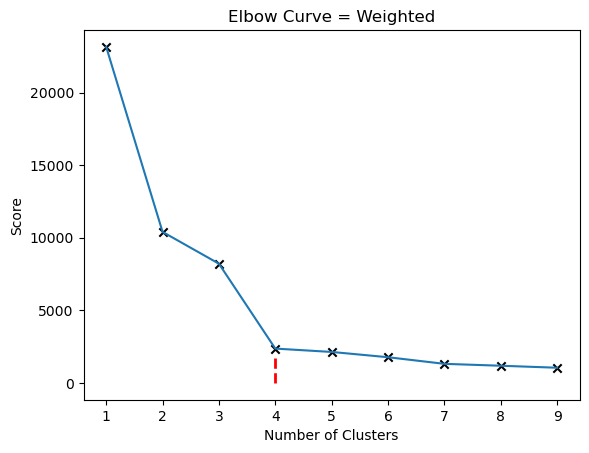

In [8]:
#decide the optimal qty of warehouse locations based on curreent vendor distribution, Elbow method (Total within sum of squares Plot)

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

lon_lat = mergeo[mergeo.columns[3:5]]
vendor_count = mergeo[mergeo.columns[6]]
sample_weight = vendor_count
ori_score = [kmeans[i].fit(lon_lat, sample_weight = vendor_count).score(lon_lat) for i in range(len(kmeans))]
score = [abs(i) for i in ori_score]

plt.plot(K_clusters, score)
plt.scatter(K_clusters, score,marker='x', color='black')
plt.plot([4, 4], [0, 2000],color='red', linestyle='dashed',linewidth=2)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve = Weighted')
plt.show()

In [14]:
#calculate the optimal coordiantes for new warehouses

kmeans = KMeans(n_clusters = 4, max_iter=300, init ='k-means++')

lon_lat = mergeo[mergeo.columns[3:5]]
lot_size = mergeo[mergeo.columns[6]]
weighted_kmeans_clusters = kmeans.fit(lon_lat, sample_weight = lot_size) # state with more vendors has more weight

mergeo['cluster_label'] = kmeans.predict(lon_lat, sample_weight = lot_size)  #assign vendors to clusters

centers = kmeans.cluster_centers_   # Coordinates of cluster centroids
centers

array([[ -96.72479319,   37.79268459],
       [-117.10946957,   38.49058157],
       [-170.37215   ,  -14.26486   ],
       [ -77.70397788,   39.67768526]])

#plot optimal warehouse locations

#xlim = (-125, -65)
#ylim = (25, 53)

fig, ax = plt.subplots(figsize=(12, 12), constrained_layout=True)
ax.axis('off')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Optimal Warehouse Locations',
             fontdict={'fontsize': '18', 'fontweight' : '3'})

from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    states = json.load(response)

fig = px.choropleth(mergeo, geojson=mergeo.geometry,
                    locations=mergeo.index, color="Vendor Count",
                    color_continuous_scale="Viridis",
                    range_color=(0, 800),
                    scope="usa")


cen = pd.DataFrame(centers)
cen.set_axis(['lat', 'lon'], axis=1, inplace=True)
cen['dot_size'] = 2000


gdf = gpd.GeoDataFrame(
    cen, geometry=gpd.points_from_xy(cen['lat'], cen['lon']))

fig2 = px.scatter_geo(cen, lat=cen['lat'], lon=cen['lon'], 
                     size = cen['dot_size'],
                     scope="usa")


fig.add_trace(
    fig2.data[0]
)
    
fig.show()

Text(0.5, 1.0, 'Optimal Warehouse Locations')

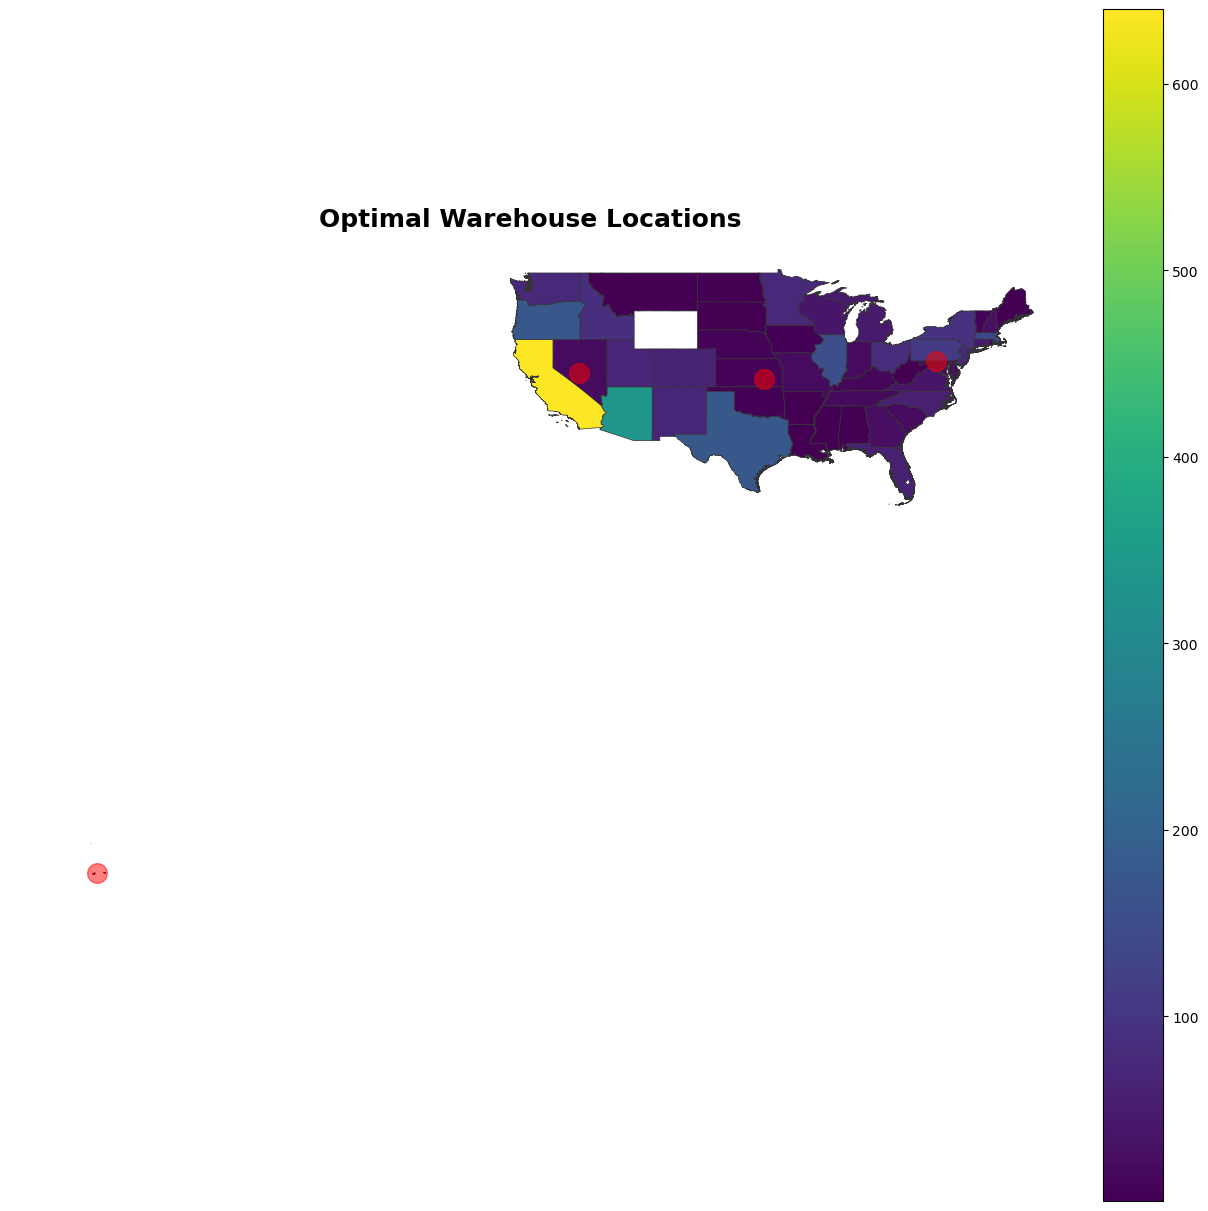

In [18]:
#plot optimal warehouse locations

#xlim = (-125, -65)
xlim = (-180, -65)
ylim = (-25, 53)

fig, ax = plt.subplots(figsize=(12, 12), constrained_layout=True)
ax.axis('off')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig = mergeo.plot(column='Vendor Count', cmap='viridis', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)  
plt.title('Optimal Warehouse Locations',fontsize=18, fontweight='bold')

In [19]:
centers

array([[ -96.72479319,   37.79268459],
       [-117.10946957,   38.49058157],
       [-170.37215   ,  -14.26486   ],
       [ -77.70397788,   39.67768526]])

In [20]:
#physical address of optimal warehouse locations

geolocator = Nominatim(user_agent="OP_loc")

location1 = geolocator.reverse("37.79268459, -96.72479319")
location2 = geolocator.reverse("39.67768526, -77.70397788")
location3 = geolocator.reverse("38.45303322, -117.14737895")
location4 = geolocator.reverse("-14.26486, -170.37215")

locations = [location1.address, location2.address, location3.address, location4.address]
locations

['Southeast 20th Street, Prospect, Butler County, Kansas, 67042, United States',
 'Keener Road, Fountain Head, Washington County, Maryland, 21742, United States',
 'Nye County, Nevada, United States',
 'United States']